In [ ]:
!unzip "/content/Siamese-LSTM-for-Semantic-Similarity-PyTorch-main.zip"

In [ ]:
import os
os.getcwd()

'/content'

In [ ]:
os.chdir("/content/Siamese-LSTM-for-Semantic-Similarity-PyTorch-main/Siamese_LSTM")

In [ ]:
os.getcwd()

'/content/Siamese-LSTM-for-Semantic-Similarity-PyTorch-main/Siamese_LSTM'

In [ ]:
!pip install wandb

In [ ]:
from siamese_lstm.model.network import EmbeddingLSTMNet, SiameseNetwork
from siamese_lstm.model.model_trainer import ModelTrainer
from siamese_lstm.model.utils import create_pretrained_weights, plotConfusionMatrix, save_model
from siamese_lstm.dataset.quora_dataset import QuoraDataset, collate
from siamese_lstm.dataset.utils import convert_data_to_tuples, text_to_wordlist
from siamese_lstm.dataset.language import Language
from siamese_lstm.model.network import EmbeddingLSTMNet, SiameseNetwork
from siamese_lstm.model.model_trainer import ModelTrainer
from siamese_lstm.model.utils import create_pretrained_weights, plotConfusionMatrix, save_model, load_model

ModuleNotFoundError: No module named 'siamese_lstm'

In [ ]:
import os
import pandas as pd
import numpy as np
import wandb

import torch
import torch.nn as nn

from torch.utils.data import DataLoader, SubsetRandomSampler

In [ ]:
ROOT_PATH = os.getcwd()
DATA_FOLDER_PATH = ROOT_PATH + '/data'
GOOGLE_EMBEDDING_FOLDER_PATH = DATA_FOLDER_PATH + '/google embedding'
GOOGLE_EMBEDDING = GOOGLE_EMBEDDING_FOLDER_PATH + '/GoogleNews-vectors-negative300.bin'
MODEL_FOLDER_PATH = ROOT_PATH
# important paths
DATASET_FILE_PATH = DATA_FOLDER_PATH + '/mini_quora_dataset_30_50_50k.csv'
EMBEDDING_PATH = GOOGLE_EMBEDDING_FOLDER_PATH + GOOGLE_EMBEDDING

# general variables
EMBEDDING_REQUIRES_GRAD = False
NUM_LAYERS = 1

In [ ]:
hparams = {
    'threshold': torch.Tensor([0.5]),  # threshold for determining similiarity
    'learning_rate': 1e-03,  # learning rate
    'epoch': 50,  # number of epochs
    'batch_size': 32,  # batch_size
    'hidden_dim': 100,  # number of hidden dimension
    'embedding_dim': 300,  # number of embedding dimension
    'dropout': 0.0,  # dropout
    'remove_stopwords': False,  # removes stopwords
    'stem_words': False,  # remove stem words
    'simple': True,  # chooses simple or more complex model
    'log_to_wandb': False,  # chooses to log to wandb or not
}

In [ ]:
df_train = pd.read_csv("/content/train.csv")
df_val = pd.read_csv("/content/validation.csv")

In [ ]:
df_train.loc[3]["support"]

'All radioactive decay is dangerous to living things, but alpha decay is the least dangerous.'

In [ ]:
q_pair = []
labels = []
for _, row in df_train.iterrows():

    q1 = text_to_wordlist(str(row['question']), hparams["remove_stopwords"], hparams["stem_words"])
    c_answer = text_to_wordlist(str(row['correct_answer']), hparams["remove_stopwords"], hparams["stem_words"])
    if q1 and c_answer:
      q_pair.append((q1, c_answer))
      labels.append(1)
    for i in range(3):
      q2 = text_to_wordlist(str(row[f'distractor{i+1}']), hparams["remove_stopwords"], hparams["stem_words"])
      if q1 and q2:
          q_pair.append((q1, q2))
          labels.append(0)

In [ ]:
import numpy as np


In [ ]:
q_pair_val = []
labels_val = []
for _, row in df_val.iterrows():

    q1 = text_to_wordlist(str(row['question']), hparams["remove_stopwords"], hparams["stem_words"])
    c_answer = text_to_wordlist(str(row['correct_answer']), hparams["remove_stopwords"], hparams["stem_words"])
    if q1 and c_answer:
      q_pair_val.append((q1, c_answer))
      labels_val.append(1)
    for i in range(3):
      q2 = text_to_wordlist(str(row[f'distractor{i+1}']), hparams["remove_stopwords"], hparams["stem_words"])
      if q1 and q2:
          q_pair_val.append((q1, q2))
          labels_val.append(0)

In [ ]:
language = Language()
for data in [q_pair]:
    for question_pair in data:
        q1 = question_pair[0]
        q2 = question_pair[1]
        language.addSentence(q1)
        language.addSentence(q2)

for data in [q_pair_val]:
    for question_pair in data:
        q1 = question_pair[0]
        q2 = question_pair[1]
        language.addSentence(q1)
        language.addSentence(q2)

In [ ]:
science_dataset = QuoraDataset(q_pair, language.word2index, labels)
science_dataset_val = QuoraDataset(q_pair_val, language.word2index, labels_val)

In [ ]:
for sample in science_dataset_val:
    print('question 1:', sample['q1'])
    print('question 2:', sample['q2'])
    print('tokens  q1:', sample['q1_token'])
    print('tokens  q2:', sample['q2_token'])
    print('labels    :', sample['labels'])
    break

question 1: who proposed the theory of evolution by natural selection
question 2: darwin
tokens  q1: [3050, 5719, 30, 2352, 3, 360, 116, 506, 960]
tokens  q2: [4935]
labels    : 1


In [ ]:
dataset_size = len(science_dataset)
train_indices = list(range(dataset_size))

val_dataset_size = len(science_dataset_val)
val_indices = list(range(val_dataset_size))


shuffle_dataset = True
random_seed = 46

if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(train_indices)

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_dataloader = torch.utils.data.DataLoader(science_dataset, batch_size=hparams['batch_size'], sampler=train_sampler, collate_fn=collate)
val_dataloader = torch.utils.data.DataLoader(science_dataset_val, batch_size=hparams['batch_size'], sampler=val_sampler, collate_fn=collate)

print('Training Set Size {}, Validation Set Size {},'.format(len(train_indices), len(val_indices)))

Training Set Size 46715, Validation Set Size 4000,


In [ ]:
pretrained_weights = torch.load('pretrained_weights.pt')
pretrained_weights

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.1396, -0.0062,  0.2148,  ...,  0.0571,  0.0996, -0.2344],
        [-0.0967, -0.0264,  0.0903,  ..., -0.0197,  0.2139,  0.1367],
        ...,
        [-0.2100, -0.3711, -0.1211,  ..., -0.0066,  0.0742, -0.0233],
        [-0.1348, -0.0233, -0.0640,  ...,  0.2051,  0.1226, -0.1250],
        [-0.0381, -0.1445,  0.1426,  ...,  0.0216,  0.0688,  0.0171]])

In [ ]:
# embedding net
embedding_net = EmbeddingLSTMNet(
    hparams['embedding_dim'],
    hparams['hidden_dim'],
    NUM_LAYERS,
    EMBEDDING_REQUIRES_GRAD,
    pretrained_weights,
    hparams['dropout'],
    hparams['simple'], # if simple=True --> simple model, if simple=False --> more complex model (2 linear layers plus relu)
)

# siamese model
model = SiameseNetwork(embedding_net)

In [ ]:
for i, batch in enumerate(train_dataloader):
    q1, q2 = batch['q1_token'], batch['q2_token']
    q1_len, q2_len = batch['q1_lengths'], batch['q2_lengths']
    y = torch.FloatTensor(batch['labels'])

model(q1, q2, q1_len, q2_len)

tensor([1.5720e-02, 1.2657e-03, 2.5271e-03, 7.9112e-03, 5.7344e-03, 1.0939e-02,
        5.1203e-03, 4.4473e-07, 3.1154e-04, 5.5937e-03, 5.2154e-03, 6.5536e-03,
        1.0790e-03, 4.3823e-03, 5.7112e-03, 5.1785e-03, 3.0308e-03, 8.0274e-07,
        1.8978e-02, 3.7704e-07, 1.6659e-03, 3.6253e-06, 3.4853e-03, 1.8401e-06,
        1.5364e-06, 1.3999e-06, 2.5967e-03], grad_fn=<CopySlices>)

In [ ]:
trainer = ModelTrainer(
    model,
    hparams,
    train_dataloader,
    val_dataloader,
    train_indices,
    val_indices,
    log_to_wandb=hparams['log_to_wandb'],
)

In [ ]:
trainer.fit()

Epoch [1/50]  Training: 100%|██████████| 1460/1460 [01:19<00:00, 18.30batch/s, train_acc=65.625 %, train_loss=0.202]


Epoch [1/50] Validation: val_loss: 0.19464700615406036 val_acc: 74.8 %


Epoch [2/50]  Training: 100%|██████████| 1460/1460 [01:22<00:00, 17.80batch/s, train_acc=71.875 %, train_loss=0.191]


Epoch [2/50] Validation: val_loss: 0.19200220292806625 val_acc: 74.925 %


Epoch [3/50]  Training: 100%|██████████| 1460/1460 [01:21<00:00, 17.84batch/s, train_acc=75.0 %, train_loss=0.185]


Epoch [3/50] Validation: val_loss: 0.19025942397117615 val_acc: 74.925 %


Epoch [4/50]  Training: 100%|██████████| 1460/1460 [01:17<00:00, 18.87batch/s, train_acc=84.375 %, train_loss=0.181]


Epoch [4/50] Validation: val_loss: 0.18918923461437226 val_acc: 75.0 %


Epoch [5/50]  Training: 100%|██████████| 1460/1460 [01:18<00:00, 18.52batch/s, train_acc=78.125 %, train_loss=0.178]


Epoch [5/50] Validation: val_loss: 0.18882612997293471 val_acc: 75.05 %


Epoch [6/50]  Training: 100%|██████████| 1460/1460 [01:16<00:00, 19.14batch/s, train_acc=75.0 %, train_loss=0.175]


Epoch [6/50] Validation: val_loss: 0.18859945386648178 val_acc: 75.075 %


Epoch [7/50]  Training: 100%|██████████| 1460/1460 [01:16<00:00, 19.06batch/s, train_acc=62.5 %, train_loss=0.173]


Epoch [7/50] Validation: val_loss: 0.1880568670630455 val_acc: 75.175 %


Epoch [8/50]  Training: 100%|██████████| 1460/1460 [01:15<00:00, 19.29batch/s, train_acc=71.875 %, train_loss=0.171]


Epoch [8/50] Validation: val_loss: 0.18770043814182283 val_acc: 75.2 %


Epoch [9/50]  Training: 100%|██████████| 1460/1460 [01:15<00:00, 19.24batch/s, train_acc=81.25 %, train_loss=0.17]


Epoch [9/50] Validation: val_loss: 0.1872672188282013 val_acc: 75.3 %


Epoch [10/50]  Training: 100%|██████████| 1460/1460 [01:16<00:00, 19.08batch/s, train_acc=87.5 %, train_loss=0.168]


Epoch [10/50] Validation: val_loss: 0.18681392705440522 val_acc: 75.225 %


Epoch [11/50]  Training: 100%|██████████| 1460/1460 [01:16<00:00, 19.11batch/s, train_acc=81.25 %, train_loss=0.167]


Epoch [11/50] Validation: val_loss: 0.18663475996255874 val_acc: 75.275 %


Epoch [12/50]  Training: 100%|██████████| 1460/1460 [01:17<00:00, 18.79batch/s, train_acc=68.75 %, train_loss=0.166]


Epoch [12/50] Validation: val_loss: 0.18680459547042846 val_acc: 75.375 %


Epoch [13/50]  Training: 100%|██████████| 1460/1460 [01:15<00:00, 19.29batch/s, train_acc=90.625 %, train_loss=0.165]


Epoch [13/50] Validation: val_loss: 0.1865341041088104 val_acc: 75.225 %


Epoch [14/50]  Training: 100%|██████████| 1460/1460 [01:16<00:00, 18.99batch/s, train_acc=78.125 %, train_loss=0.165]


Epoch [14/50] Validation: val_loss: 0.1861689081788063 val_acc: 75.4 %


Epoch [15/50]  Training: 100%|██████████| 1460/1460 [01:16<00:00, 18.97batch/s, train_acc=71.875 %, train_loss=0.164]


Epoch [15/50] Validation: val_loss: 0.18603657990694045 val_acc: 75.35 %


Epoch [16/50]  Training: 100%|██████████| 1460/1460 [01:15<00:00, 19.27batch/s, train_acc=68.75 %, train_loss=0.163]


Epoch [16/50] Validation: val_loss: 0.18611877405643462 val_acc: 75.35 %


Epoch [17/50]  Training: 100%|██████████| 1460/1460 [01:21<00:00, 17.98batch/s, train_acc=87.5 %, train_loss=0.162]


Epoch [17/50] Validation: val_loss: 0.1861289051771164 val_acc: 75.325 %


Epoch [18/50]  Training: 100%|██████████| 1460/1460 [01:17<00:00, 18.87batch/s, train_acc=81.25 %, train_loss=0.161]


Epoch [18/50] Validation: val_loss: 0.1860496551990509 val_acc: 75.425 %


Epoch [19/50]  Training: 100%|██████████| 1460/1460 [01:16<00:00, 19.02batch/s, train_acc=78.125 %, train_loss=0.161]


Epoch [19/50] Validation: val_loss: 0.18589205414056778 val_acc: 75.375 %


Epoch [20/50]  Training: 100%|██████████| 1460/1460 [01:15<00:00, 19.25batch/s, train_acc=68.75 %, train_loss=0.161]


Epoch [20/50] Validation: val_loss: 0.18595123714208603 val_acc: 75.35 %


Epoch [21/50]  Training: 100%|██████████| 1460/1460 [01:17<00:00, 18.81batch/s, train_acc=93.75 %, train_loss=0.161]


Epoch [21/50] Validation: val_loss: 0.18593654012680053 val_acc: 75.425 %


Epoch [22/50]  Training: 100%|██████████| 1460/1460 [01:16<00:00, 19.04batch/s, train_acc=71.875 %, train_loss=0.16]


Epoch [22/50] Validation: val_loss: 0.18576563459634782 val_acc: 75.35 %


Epoch [23/50]  Training: 100%|██████████| 1460/1460 [01:15<00:00, 19.44batch/s, train_acc=62.5 %, train_loss=0.16]


Epoch [23/50] Validation: val_loss: 0.18577163696289062 val_acc: 75.35 %


Epoch [24/50]  Training: 100%|██████████| 1460/1460 [01:15<00:00, 19.29batch/s, train_acc=75.0 %, train_loss=0.16]


Epoch [24/50] Validation: val_loss: 0.18578116476535797 val_acc: 75.375 %


Epoch [25/50]  Training: 100%|██████████| 1460/1460 [01:14<00:00, 19.70batch/s, train_acc=81.25 %, train_loss=0.16]


Epoch [25/50] Validation: val_loss: 0.18571872925758362 val_acc: 75.375 %


Epoch [26/50]  Training: 100%|██████████| 1460/1460 [01:14<00:00, 19.53batch/s, train_acc=65.625 %, train_loss=0.159]


Epoch [26/50] Validation: val_loss: 0.1857122070789337 val_acc: 75.425 %


Epoch [27/50]  Training: 100%|██████████| 1460/1460 [01:16<00:00, 19.18batch/s, train_acc=84.375 %, train_loss=0.159]


Epoch [27/50] Validation: val_loss: 0.18565979725122453 val_acc: 75.425 %


Epoch [28/50]  Training: 100%|██████████| 1460/1460 [01:15<00:00, 19.36batch/s, train_acc=75.0 %, train_loss=0.159]


Epoch [28/50] Validation: val_loss: 0.18567350625991821 val_acc: 75.35 %


Epoch [29/50]  Training: 100%|██████████| 1460/1460 [01:15<00:00, 19.38batch/s, train_acc=71.875 %, train_loss=0.159]


Epoch [29/50] Validation: val_loss: 0.18564125072956086 val_acc: 75.4 %


Epoch [30/50]  Training: 100%|██████████| 1460/1460 [01:15<00:00, 19.34batch/s, train_acc=81.25 %, train_loss=0.158]


Epoch [30/50] Validation: val_loss: 0.18561637961864472 val_acc: 75.425 %


Epoch [31/50]  Training: 100%|██████████| 1460/1460 [01:15<00:00, 19.27batch/s, train_acc=65.625 %, train_loss=0.159]


Epoch [31/50] Validation: val_loss: 0.18563487863540648 val_acc: 75.4 %


Epoch [32/50]  Training: 100%|██████████| 1460/1460 [01:15<00:00, 19.38batch/s, train_acc=84.375 %, train_loss=0.158]


Epoch [32/50] Validation: val_loss: 0.18558455336093901 val_acc: 75.44999999999999 %


Epoch [33/50]  Training: 100%|██████████| 1460/1460 [01:16<00:00, 19.17batch/s, train_acc=81.25 %, train_loss=0.158]


Epoch [33/50] Validation: val_loss: 0.18558892607688904 val_acc: 75.4 %


Epoch [34/50]  Training: 100%|██████████| 1460/1460 [01:15<00:00, 19.26batch/s, train_acc=71.875 %, train_loss=0.158]


Epoch [34/50] Validation: val_loss: 0.1855889413356781 val_acc: 75.4 %


Epoch [35/50]  Training: 100%|██████████| 1460/1460 [01:14<00:00, 19.53batch/s, train_acc=68.75 %, train_loss=0.158]


Epoch [35/50] Validation: val_loss: 0.18557924628257752 val_acc: 75.425 %


Epoch [36/50]  Training: 100%|██████████| 1460/1460 [01:15<00:00, 19.45batch/s, train_acc=71.875 %, train_loss=0.158]


Epoch [36/50] Validation: val_loss: 0.18557661020755767 val_acc: 75.4 %


Epoch [37/50]  Training: 100%|██████████| 1460/1460 [01:14<00:00, 19.47batch/s, train_acc=71.875 %, train_loss=0.158]


Epoch [37/50] Validation: val_loss: 0.18556220984458924 val_acc: 75.4 %


Epoch [38/50]  Training: 100%|██████████| 1460/1460 [01:15<00:00, 19.42batch/s, train_acc=68.75 %, train_loss=0.158]


Epoch [38/50] Validation: val_loss: 0.18556151431798934 val_acc: 75.4 %


Epoch [39/50]  Training: 100%|██████████| 1460/1460 [01:16<00:00, 19.20batch/s, train_acc=78.125 %, train_loss=0.158]


Epoch [39/50] Validation: val_loss: 0.18556543672084808 val_acc: 75.425 %


Epoch [40/50]  Training: 100%|██████████| 1460/1460 [01:16<00:00, 19.19batch/s, train_acc=75.0 %, train_loss=0.158]


Epoch [40/50] Validation: val_loss: 0.18554937398433685 val_acc: 75.4 %


Epoch [41/50]  Training: 100%|██████████| 1460/1460 [01:16<00:00, 19.16batch/s, train_acc=81.25 %, train_loss=0.157]


Epoch [41/50] Validation: val_loss: 0.1855525130033493 val_acc: 75.425 %


Epoch [42/50]  Training: 100%|██████████| 1460/1460 [01:16<00:00, 19.18batch/s, train_acc=84.375 %, train_loss=0.158]


Epoch [42/50] Validation: val_loss: 0.1855344850420952 val_acc: 75.4 %


Epoch [43/50]  Training: 100%|██████████| 1460/1460 [01:17<00:00, 18.93batch/s, train_acc=59.375 %, train_loss=0.157]


Epoch [43/50] Validation: val_loss: 0.18554202157258987 val_acc: 75.4 %


Epoch [44/50]  Training: 100%|██████████| 1460/1460 [01:15<00:00, 19.24batch/s, train_acc=81.25 %, train_loss=0.157]


Epoch [44/50] Validation: val_loss: 0.18553240215778352 val_acc: 75.4 %


Epoch [45/50]  Training: 100%|██████████| 1460/1460 [01:15<00:00, 19.32batch/s, train_acc=78.125 %, train_loss=0.158]


Epoch [45/50] Validation: val_loss: 0.18553779101371765 val_acc: 75.425 %


Epoch [46/50]  Training: 100%|██████████| 1460/1460 [01:15<00:00, 19.23batch/s, train_acc=87.5 %, train_loss=0.157]


Epoch [46/50] Validation: val_loss: 0.18553164583444595 val_acc: 75.4 %


Epoch [47/50]  Training: 100%|██████████| 1460/1460 [01:16<00:00, 19.15batch/s, train_acc=65.625 %, train_loss=0.158]


Epoch [47/50] Validation: val_loss: 0.18553514152765274 val_acc: 75.4 %


Epoch [48/50]  Training: 100%|██████████| 1460/1460 [01:17<00:00, 18.83batch/s, train_acc=71.875 %, train_loss=0.157]


Epoch [48/50] Validation: val_loss: 0.1855302608013153 val_acc: 75.4 %


Epoch [49/50]  Training: 100%|██████████| 1460/1460 [01:17<00:00, 18.87batch/s, train_acc=68.75 %, train_loss=0.157]


Epoch [49/50] Validation: val_loss: 0.18552947634458541 val_acc: 75.4 %


Epoch [50/50]  Training: 100%|██████████| 1460/1460 [01:18<00:00, 18.53batch/s, train_acc=75.0 %, train_loss=0.157]


Epoch [50/50] Validation: val_loss: 0.18552858221530916 val_acc: 75.4 %


- - - Model Performance - - -

Model Accuracy:  75.4
Correct predictions: 3016, Incorret predictions: 984



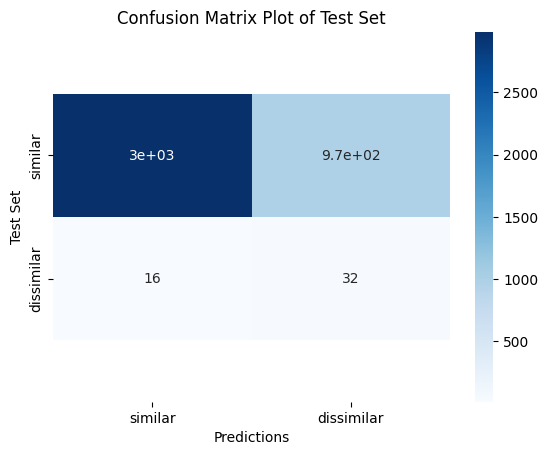

TP: 2984
FP: 16
FN: 968
TN: 32

Precision Score: 0.032
Recall Score: 0.6666666666666666
F1 Score: 0.061068702290076333


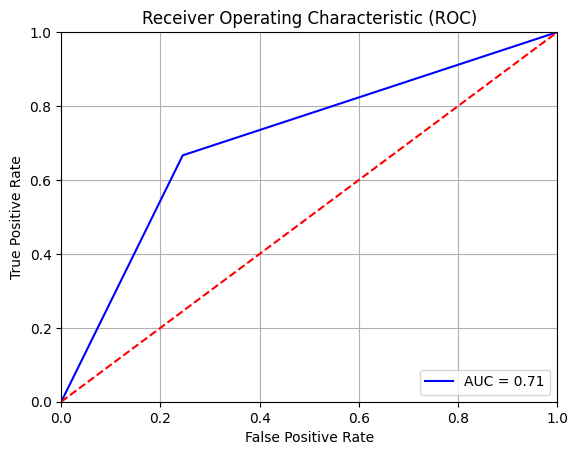

In [ ]:
trainer.test()

In [ ]:
filename = "model.pt"
save_model(model, "/content" + "/" + filename)

In [ ]:
ind = np.random.choice(len(train_dataloader))
test_sample_train = dict()
for idx, batch in enumerate(train_dataloader):
    if idx == ind:
        test_sample_train['q1_text'] = [batch['q1_text'][0]]
        test_sample_train['q2_text'] = [batch['q2_text'][0]]
        test_sample_train['q1_token'] = [batch['q1_token'][0]]
        test_sample_train['q2_token'] = [batch['q2_token'][0]]
        test_sample_train['q1_lengths'] = [batch['q1_lengths'][0]]
        test_sample_train['q2_lengths'] = [batch['q2_lengths'][0]]
        test_sample_train['labels'] = [batch['labels'][0]]

trainer.predict(test_sample_train)

question 1: ['maintaining a balance inside the body or cells of organisms is known as']
question 2: ['ketosis']
tokens  q1: [[1200, 44, 1622, 1522, 30, 222, 29, 220, 3, 17, 5, 318, 12]]
tokens  q2: [[2286]]


Model predicts 0.0 --> Actual value 0.0
Model prediction is correct :)

The questions ['maintaining a balance inside the body or cells of organisms is known as'] and ['ketosis'] are dissimilar!


In [ ]:
|

# Testing on Trained Model

In [ ]:
new_model_weights = torch.load('model.pt')
new_model_weights

In [ ]:
embedding_net = EmbeddingLSTMNet(
    hparams['embedding_dim'],
    hparams['hidden_dim'],
    NUM_LAYERS,
    EMBEDDING_REQUIRES_GRAD,
    pretrained_weights,
    hparams['dropout'],
    hparams['simple'], # if simple=True --> simple model, if simple=False --> more complex model (2 linear layers plus relu)
)

# siamese model
model = SiameseNetwork(embedding_net)

In [ ]:
model.load_state_dict(torch.load("/content/Github_model.pt"))

<All keys matched successfully>

In [ ]:
trainer = ModelTrainer(
    model,
    hparams,
    train_dataloader,
    val_dataloader,
    train_indices,
    val_indices,
    log_to_wandb=hparams['log_to_wandb'],
)

In [ ]:
ind = np.random.choice(len(val_dataloader))
test_sample_val = dict()
for idx, batch in enumerate(val_dataloader):
    if idx == ind:
        test_sample_val['q1_text'] = [batch['q1_text'][0]]
        test_sample_val['q2_text'] = [batch['q2_text'][0]]
        test_sample_val['q1_token'] = [batch['q1_token'][0]]
        test_sample_val['q2_token'] = [batch['q2_token'][0]]
        test_sample_val['q1_lengths'] = [batch['q1_lengths'][0]]
        test_sample_val['q2_lengths'] = [batch['q2_lengths'][0]]
        test_sample_val['labels'] = [batch['labels'][0]]

trainer.predict(test_sample_val)

question 1: ['kinetic theory is the atomistic description of what as well as liquids and solids']
question 2: ['gases']
tokens  q1: [[341, 2352, 5, 30, 14557, 14558, 3, 1, 12, 1808, 12, 4066, 14, 1247]]
tokens  q2: [[88]]


Model predicts 0.0 --> Actual value 1.0
Model prediction is inaccurate :(

The questions ['kinetic theory is the atomistic description of what as well as liquids and solids'] and ['gases'] should be similar!


In [ ]:
default = True  # set to False to create your own inputs
similar = False  # select False to dispaly dissimlar example

if default:
    if similar:
        q1 = ['Is it cold today?']
        q2 = ['Will it be cold today?']
        label = [1.0]
    else:
        q1 = ['Will I pass the final?']
        q2 = ['What will I have for dinner tonight?']
        label = [0.0]
else:
    q1 = input(r'Enter your 1^st question: ')
    q2 = input(r'Enter your 2^nd question: ')
    label = input('label: ') # 0 for dissimilar, 1 for similar
    q1 = [q1]
    q2 = [q2]
    label = [label]

In [ ]:
df_own = pd.DataFrame(list(zip(q1, q2, label)), columns=['question1', 'question2', 'is_duplicate'])
# prepare data
q_pair_own, label = convert_data_to_tuples(df_own, hparams['remove_stopwords'], hparams['stem_words'])
print(q_pair_own)

# create dataset
own_dataset = QuoraDataset(q_pair_own, language.word2index, label)

# create dataloader
predict_dataloader = torch.utils.data.DataLoader(own_dataset, batch_size=1, collate_fn=collate)

for sample in predict_dataloader:
    test_sample = sample

# predict
trainer.predict(test_sample)

Question Pairs:  1
[('will i pass the final', 'what will i have for dinner tonight')]


KeyError: 'dinner'